# Sebességprofil számítás és különböző numerikus módszerek összehasonlítása

## Importok és kisegítő függvények

### Importok

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Numerikus módszerek kimenetének tesztelésére

In [2]:
def test_numeric_method(func, title, funcArgs = None):
    x_vals_test = np.linspace(-1,1,1000)
    y_vals_test = list()

    if funcArgs:
        for x in x_vals_test:
            y_vals_test.append(func(x, funcArgs))
    else:
        for x in x_vals_test:
            y_vals_test.append(func(x))

    plt.plot(x_vals_test,y_vals_test)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('~ -arcsin(x)')
    plt.grid()

### Plottolást segítő függvények

In [3]:
def T_omega_texts(ax1: plt.axes, ax2: plt.axes, times: np.array, omegas: np.array, thetas: np.array, d_times_summed: np.array) -> None:
    T_text = r"$T= $" + f"{np.round(np.nanmax(times), 3)}" + r" $[s]$"
    ax1.text(np.nanmax(times) - 0.09, np.nanmax(thetas)/2, 
            T_text,
            ha = 'right',
            va = 'center',
            rotation = 'vertical',
            bbox=dict(facecolor='red', alpha=0.3, boxstyle = 'round', ec = 'red')
            )

    omega_max_text = r"$\omega_{max} = $" + f"{np.round(np.nanmax(omegas), 3)}" + r" $[\frac{rad}{s}]$"
    ax2.text(np.nanmax(d_times_summed)/2, np.nanmax(omegas)+0.07, 
            omega_max_text,
            ha = 'center',
            bbox=dict(facecolor='blue', alpha=0.3, boxstyle = 'round', ec = 'blue')
            )

## Numerikus módszerek függvényei

### LUT

In [4]:
def generate_arcsin_LUT(N):
    x_vals = np.linspace(0,1,N)
    y_vals = -np.arcsin(x_vals)
    return x_vals, y_vals

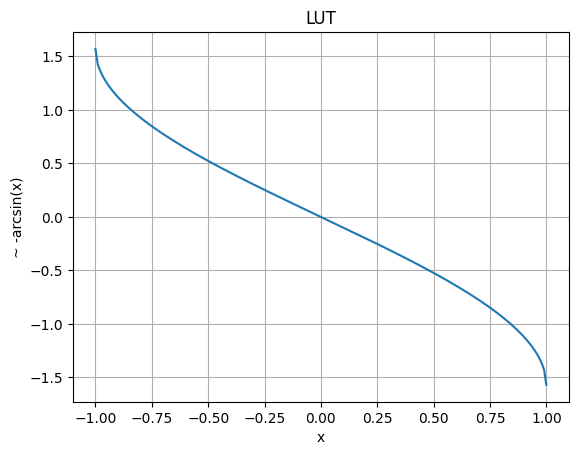

In [5]:
def lookup_arcsin(x, LUT):
    x_vals = LUT[0]
    y_vals = LUT[1]

    sign = 1

    if x < 0:
        sign = -1
        x = -x
    
    if x <= x_vals[0]:
        return sign * y_vals[0]
    elif x >= x_vals[-1]:
        return sign * y_vals[-1]
    
    idx = np.searchsorted(x_vals, x) - 1
    x0, x1 = x_vals[idx], x_vals[idx+1]
    y0, y1 = y_vals[idx], y_vals[idx+1]
    
    #linear approximation

    dy_dx = (y1 - y0) / (x1 - x0)
    dt = x - x0
    y = y0 + (dy_dx * dt)

    return sign * y

LUT_TEST = generate_arcsin_LUT(100)
test_numeric_method(lookup_arcsin, title = 'LUT', funcArgs = LUT_TEST)

### Taylor sor

In [6]:
def pow_3_5_7_9(num):
    pow_3 = num*num*num
    pow_5 = pow_3*num*num
    pow_7 = pow_5*num*num
    pow_9 = pow_7*num*num
    return pow_3,pow_5,pow_7,pow_9

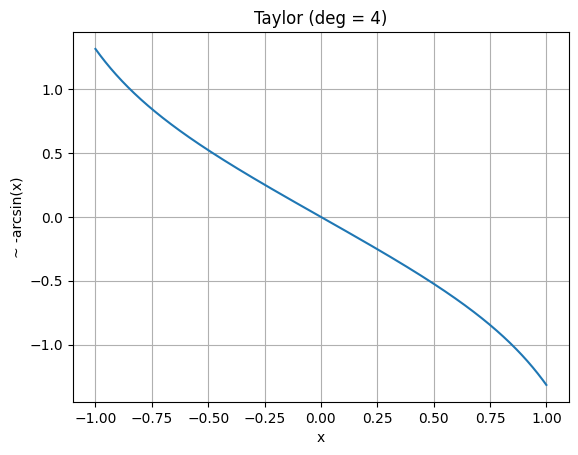

In [7]:
def minus_asin_taylor(x):
    x_pows = pow_3_5_7_9(x)
    return  - x -                   \
            x_pows[0]/6 -           \
            3 * x_pows[1] / 40 -    \
            5 * x_pows[2] / 112 -   \
            35 * x_pows[3] / 1152

test_numeric_method(minus_asin_taylor, title = 'Taylor (deg = 4)')

### Aszimptotikus közelítés

In [8]:
def pow_2_3_4(num):
    pow_2 = num*num
    pow_3 = pow_2*num
    pow_4 = pow_3*num
    return pow_2, pow_3, pow_4

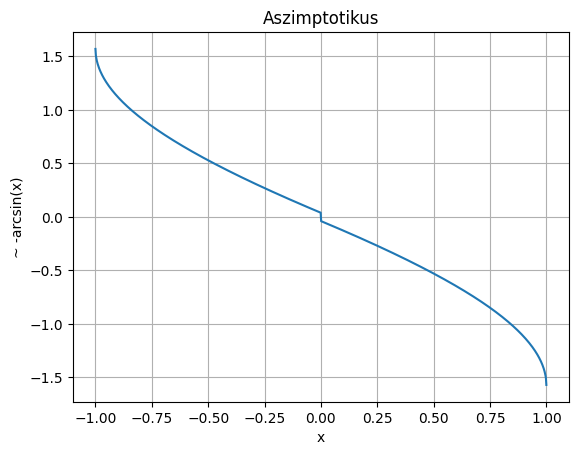

In [9]:
def minus_asin_identity_for_negatives(x):
    pows = pow_2_3_4(1 - x)
    return np.pi/2 - np.sqrt(2 * (1+x)) * ( 
                                            1 + 
                                            1/12 * (1+x) #+
                                            #3/160 * pows[0] +
                                            #5/896 * pows[1] +
                                            #35/18432 * pows[2]
                                           )


def minus_asin_identity(x):
    if( x < 0):
        return minus_asin_identity_for_negatives(x)
    elif( x > 0):
        return -1 * minus_asin_identity_for_negatives(-x)
    else:
        return 0

test_numeric_method(minus_asin_identity, title = 'Aszimptotikus')

## Példaszámítás és eredmények összehasonlítása

$t_k$ számítása

In [10]:
def calculate_tk(func, k, Theta_rad, T, alpha_rad, funcArgs = None):
    if funcArgs:
        return (func( 1 - 2 * (k * alpha_rad)/Theta_rad, funcArgs) + np.pi/2) * T/np.pi
    else:
        return (func( 1 - 2 * (k * alpha_rad)/Theta_rad) + np.pi/2) * T/np.pi

konstansok

In [11]:
freq_tmr = 84e6     #[Hz]
full_step = 1.8      #[deg/step]
micro_steps = 1/8

alpha = full_step * micro_steps #[deg/pulse]
alpha_rad = (alpha * np.pi/180)


### Adott $\Theta$ és T

In [12]:
Theta = 90          #[deg]
T = 2

n_steps = int(Theta/alpha)
Theta_rad = np.deg2rad(Theta)


LUT_res = 100
LUT = generate_arcsin_LUT(LUT_res)

times_exact = []
times_taylor = []
times_identity = []
times_LUT = []

for k in range(n_steps+1):
    t_k_exact =     (-np.arcsin( 1 - 2 * (k * alpha_rad)/Theta_rad ) + np.pi/2) * T/np.pi
    
    t_k_taylor =    calculate_tk(minus_asin_taylor, k, Theta_rad, T, alpha_rad) # -> Relevant error (~20%)
    t_k_identity =  calculate_tk(minus_asin_identity, k, Theta_rad, T, alpha_rad) # -> jump in 0
    t_k_LUT =       calculate_tk(lookup_arcsin, k, Theta_rad, T, alpha_rad, LUT)

    times_exact.append(t_k_exact)
    times_taylor.append(t_k_taylor)
    times_identity.append(t_k_identity)
    times_LUT.append(t_k_LUT)

d_times_exact = np.diff(times_exact)
d_times_taylor = np.diff(times_taylor)
d_times_identity = np.diff(times_identity)
d_times_LUT = np.diff(times_LUT)

d_times_summed_exact = [] # to check the theory
d_times_summed_taylor = [] # to check the theory
d_times_summed_identity = [] # to check the theory
d_times_summed_LUT = [] # to check the theory


integrated_speed_exact = []
integrated_speed_taylor = []
integrated_speed_identity = []
integrated_speed_LUT = []

# speed in rad/sec
speed_exact = alpha_rad / d_times_exact
speed_taylor = alpha_rad / d_times_taylor
speed_identity = alpha_rad / d_times_identity
speed_LUT = alpha_rad / d_times_LUT



# sum for cont
sum = 0
sum_int = 0
for dt in d_times_exact:
    sum += dt
    d_times_summed_exact.append(sum)

    sum_int += (alpha_rad/dt)*dt
    integrated_speed_exact.append(sum_int)

#sum for taylor
sum = 0
sum_int = 0
for dt in d_times_taylor:
    sum += dt
    d_times_summed_taylor.append(sum)

    sum_int += (alpha_rad/dt)*dt
    integrated_speed_taylor.append(sum_int)

#sum for identity
sum = 0
sum_int = 0
for dt in d_times_identity:
    sum += dt
    d_times_summed_identity.append(sum)

    sum_int += (alpha_rad/dt)*dt
    integrated_speed_identity.append(sum_int)

#sum for LUT
sum = 0
sum_int = 0
for dt in d_times_LUT:
    sum += dt
    d_times_summed_LUT.append(sum)

    sum_int += (alpha_rad/dt)*dt
    integrated_speed_LUT.append(sum_int)

C:\Users\SNA1BP\AppData\Local\Temp\ipykernel_27280\1138873379.py:17: RuntimeWarning: invalid value encountered in arcsin
  t_k_exact =     (-np.arcsin( 1 - 2 * (k * alpha_rad)/Theta_rad ) + np.pi/2) * T/np.pi
C:\Users\SNA1BP\AppData\Local\Temp\ipykernel_27280\3068500112.py:3: RuntimeWarning: invalid value encountered in sqrt
  return np.pi/2 - np.sqrt(2 * (1+x)) * (


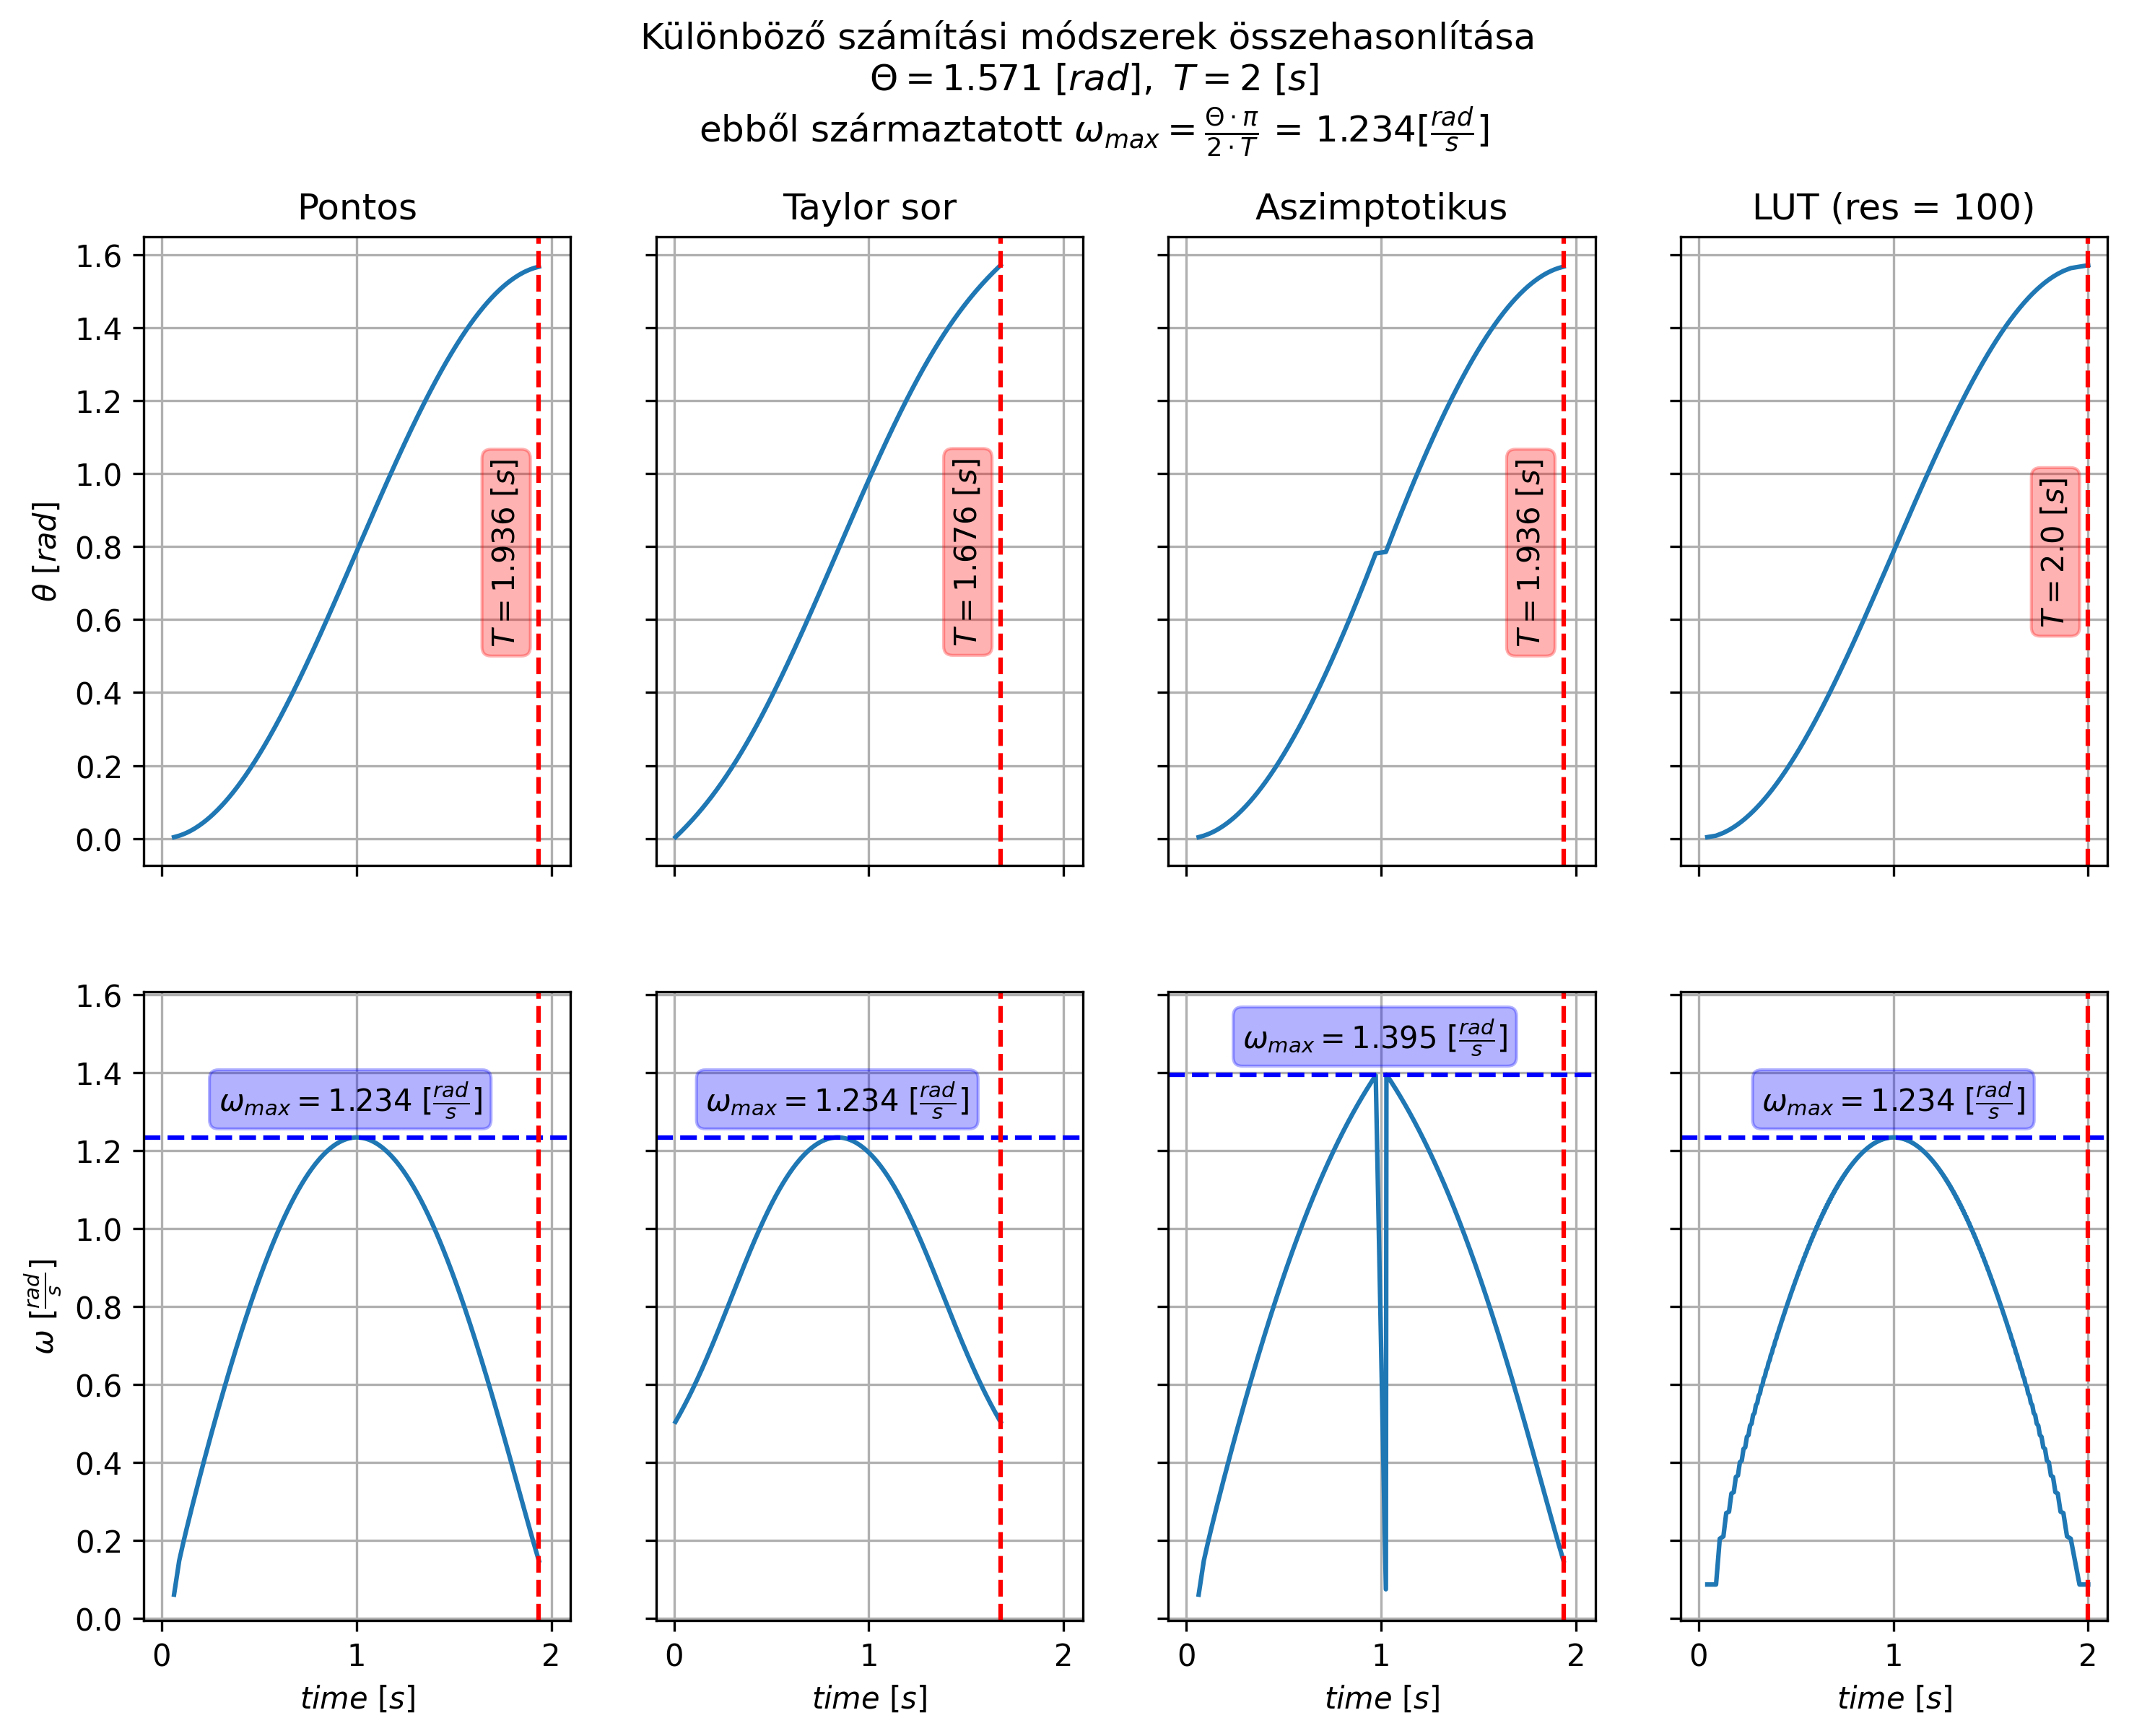

In [13]:
fig, ((ax11, ax12, ax13, ax14), (ax21, ax22, ax23, ax24)) = plt.subplots(2, 4, sharey = 'row', sharex = True)


omega_max_calculated = (Theta_rad * np.pi )/( 2 * T )

title = "Különböző számítási módszerek összehasonlítása \n" + \
        fr"$\Theta = {np.round(Theta_rad, 3)} \ [rad], \ T = {T} \ [s]$" + "\n" + \
        r"ebből származtatott $\omega_{max} = \frac{\Theta \cdot \pi}{2 \cdot T}$" + f" = {np.round(omega_max_calculated, 3)}" + r"$[\frac{rad}{s}]$"

fig.suptitle(title, y = 1)

fig.set_size_inches(11.7,8.3)
fig.set_dpi(300)

ax11.plot(d_times_summed_exact, integrated_speed_exact)
ax21.plot(d_times_summed_exact, speed_exact)

ax21.axhline(np.nanmax(speed_exact), color = 'blue', ls = '--')
ax11.axvline(np.nanmax(d_times_summed_exact), color = 'red', ls = '--')
ax21.axvline(np.nanmax(d_times_summed_exact), color = 'red', ls = '--')

T_omega_texts(ax11, ax21, d_times_summed_exact, speed_exact, integrated_speed_exact, d_times_summed_exact)
ax11.set_title("Pontos")



ax12.plot(d_times_summed_taylor, integrated_speed_taylor)
ax22.plot(d_times_summed_taylor, speed_taylor)

ax22.axhline(speed_taylor.max(), color = 'blue', ls = '--')
ax12.axvline(d_times_summed_taylor[-1], color = 'red', ls = '--')
ax22.axvline(d_times_summed_taylor[-1], color = 'red', ls = '--')

T_omega_texts(ax12, ax22, d_times_summed_taylor, speed_taylor, integrated_speed_taylor, d_times_summed_taylor)
ax12.set_title("Taylor sor")



ax13.plot(d_times_summed_identity, integrated_speed_identity)
ax23.plot(d_times_summed_identity, speed_identity)

ax23.axhline(np.nanmax(speed_identity), color = 'blue', ls = '--')
ax13.axvline(np.nanmax(d_times_summed_identity), color = 'red', ls = '--')
ax23.axvline(np.nanmax(d_times_summed_identity), color = 'red', ls = '--')

T_omega_texts(ax13, ax23, d_times_summed_identity, speed_identity, integrated_speed_identity, d_times_summed_identity)
ax13.set_title("Aszimptotikus")



ax14.plot(d_times_summed_LUT, integrated_speed_LUT)
ax24.plot(d_times_summed_LUT, speed_LUT)

ax24.axhline(speed_LUT.max(), color = 'blue', ls = '--')
ax14.axvline(d_times_summed_LUT[-1], color = 'red', ls = '--')
ax24.axvline(d_times_summed_LUT[-1], color = 'red', ls = '--')

T_omega_texts(ax14, ax24, d_times_summed_LUT, speed_LUT, integrated_speed_LUT, d_times_summed_LUT)
ax14.set_title(f"LUT (res = {LUT_res})")

ax11.set_ylabel(r'$\theta\ [rad]$')
ax21.set_ylabel(r'$\omega\ [\frac{rad}{s}]$')

ax23.set_ylim(ax23.get_ylim()[0], ax23.get_ylim()[1]*1.1)

for ax in fig.get_axes():
    ax.grid()
    ax.set_xlabel(r'$time\ [s]$')
    ax.label_outer()

### Adott $\Theta$ és $\omega_{max}$

In [14]:
Theta = 90      #[deg]
omega_max = 3   #[rad/sec]


n_steps = int(Theta/alpha)
Theta_rad = np.deg2rad(Theta)
T = ( np.pi * Theta_rad ) / ( 2 * omega_max )


LUT_res = 100
LUT = generate_arcsin_LUT(LUT_res)

times_exact = []
times_taylor = []
times_identity = []
times_LUT = []

for k in range(n_steps+1):
    t_k_exact =     (-np.arcsin( 1 - 2 * (k * alpha_rad)/Theta_rad ) + np.pi/2) * T/np.pi
    
    t_k_taylor =    calculate_tk(minus_asin_taylor, k, Theta_rad, T, alpha_rad) # -> Relevant error (~20%)
    t_k_identity =  calculate_tk(minus_asin_identity, k, Theta_rad, T, alpha_rad) # -> jump in 0
    t_k_LUT =       calculate_tk(lookup_arcsin, k, Theta_rad, T, alpha_rad, LUT)

    times_exact.append(t_k_exact)
    times_taylor.append(t_k_taylor)
    times_identity.append(t_k_identity)
    times_LUT.append(t_k_LUT)

d_times_exact = np.diff(times_exact)
d_times_taylor = np.diff(times_taylor)
d_times_identity = np.diff(times_identity)
d_times_LUT = np.diff(times_LUT)

d_times_summed_exact = [] # to check the theory
d_times_summed_taylor = [] # to check the theory
d_times_summed_identity = [] # to check the theory
d_times_summed_LUT = [] # to check the theory


integrated_speed_exact = []
integrated_speed_taylor = []
integrated_speed_identity = []
integrated_speed_LUT = []

# speed in rad/sec
speed_exact = alpha_rad / d_times_exact
speed_taylor = alpha_rad / d_times_taylor
speed_identity = alpha_rad / d_times_identity
speed_LUT = alpha_rad / d_times_LUT



# sum for cont
sum = 0
sum_int = 0
for dt in d_times_exact:
    sum += dt
    d_times_summed_exact.append(sum)

    sum_int += (alpha_rad/dt)*dt
    integrated_speed_exact.append(sum_int)

#sum for taylor
sum = 0
sum_int = 0
for dt in d_times_taylor:
    sum += dt
    d_times_summed_taylor.append(sum)

    sum_int += (alpha_rad/dt)*dt
    integrated_speed_taylor.append(sum_int)

#sum for identity
sum = 0
sum_int = 0
for dt in d_times_identity:
    sum += dt
    d_times_summed_identity.append(sum)

    sum_int += (alpha_rad/dt)*dt
    integrated_speed_identity.append(sum_int)

#sum for LUT
sum = 0
sum_int = 0
for dt in d_times_LUT:
    sum += dt
    d_times_summed_LUT.append(sum)

    sum_int += (alpha_rad/dt)*dt
    integrated_speed_LUT.append(sum_int)

C:\Users\SNA1BP\AppData\Local\Temp\ipykernel_27280\20935722.py:19: RuntimeWarning: invalid value encountered in arcsin
  t_k_exact =     (-np.arcsin( 1 - 2 * (k * alpha_rad)/Theta_rad ) + np.pi/2) * T/np.pi
C:\Users\SNA1BP\AppData\Local\Temp\ipykernel_27280\3068500112.py:3: RuntimeWarning: invalid value encountered in sqrt
  return np.pi/2 - np.sqrt(2 * (1+x)) * (


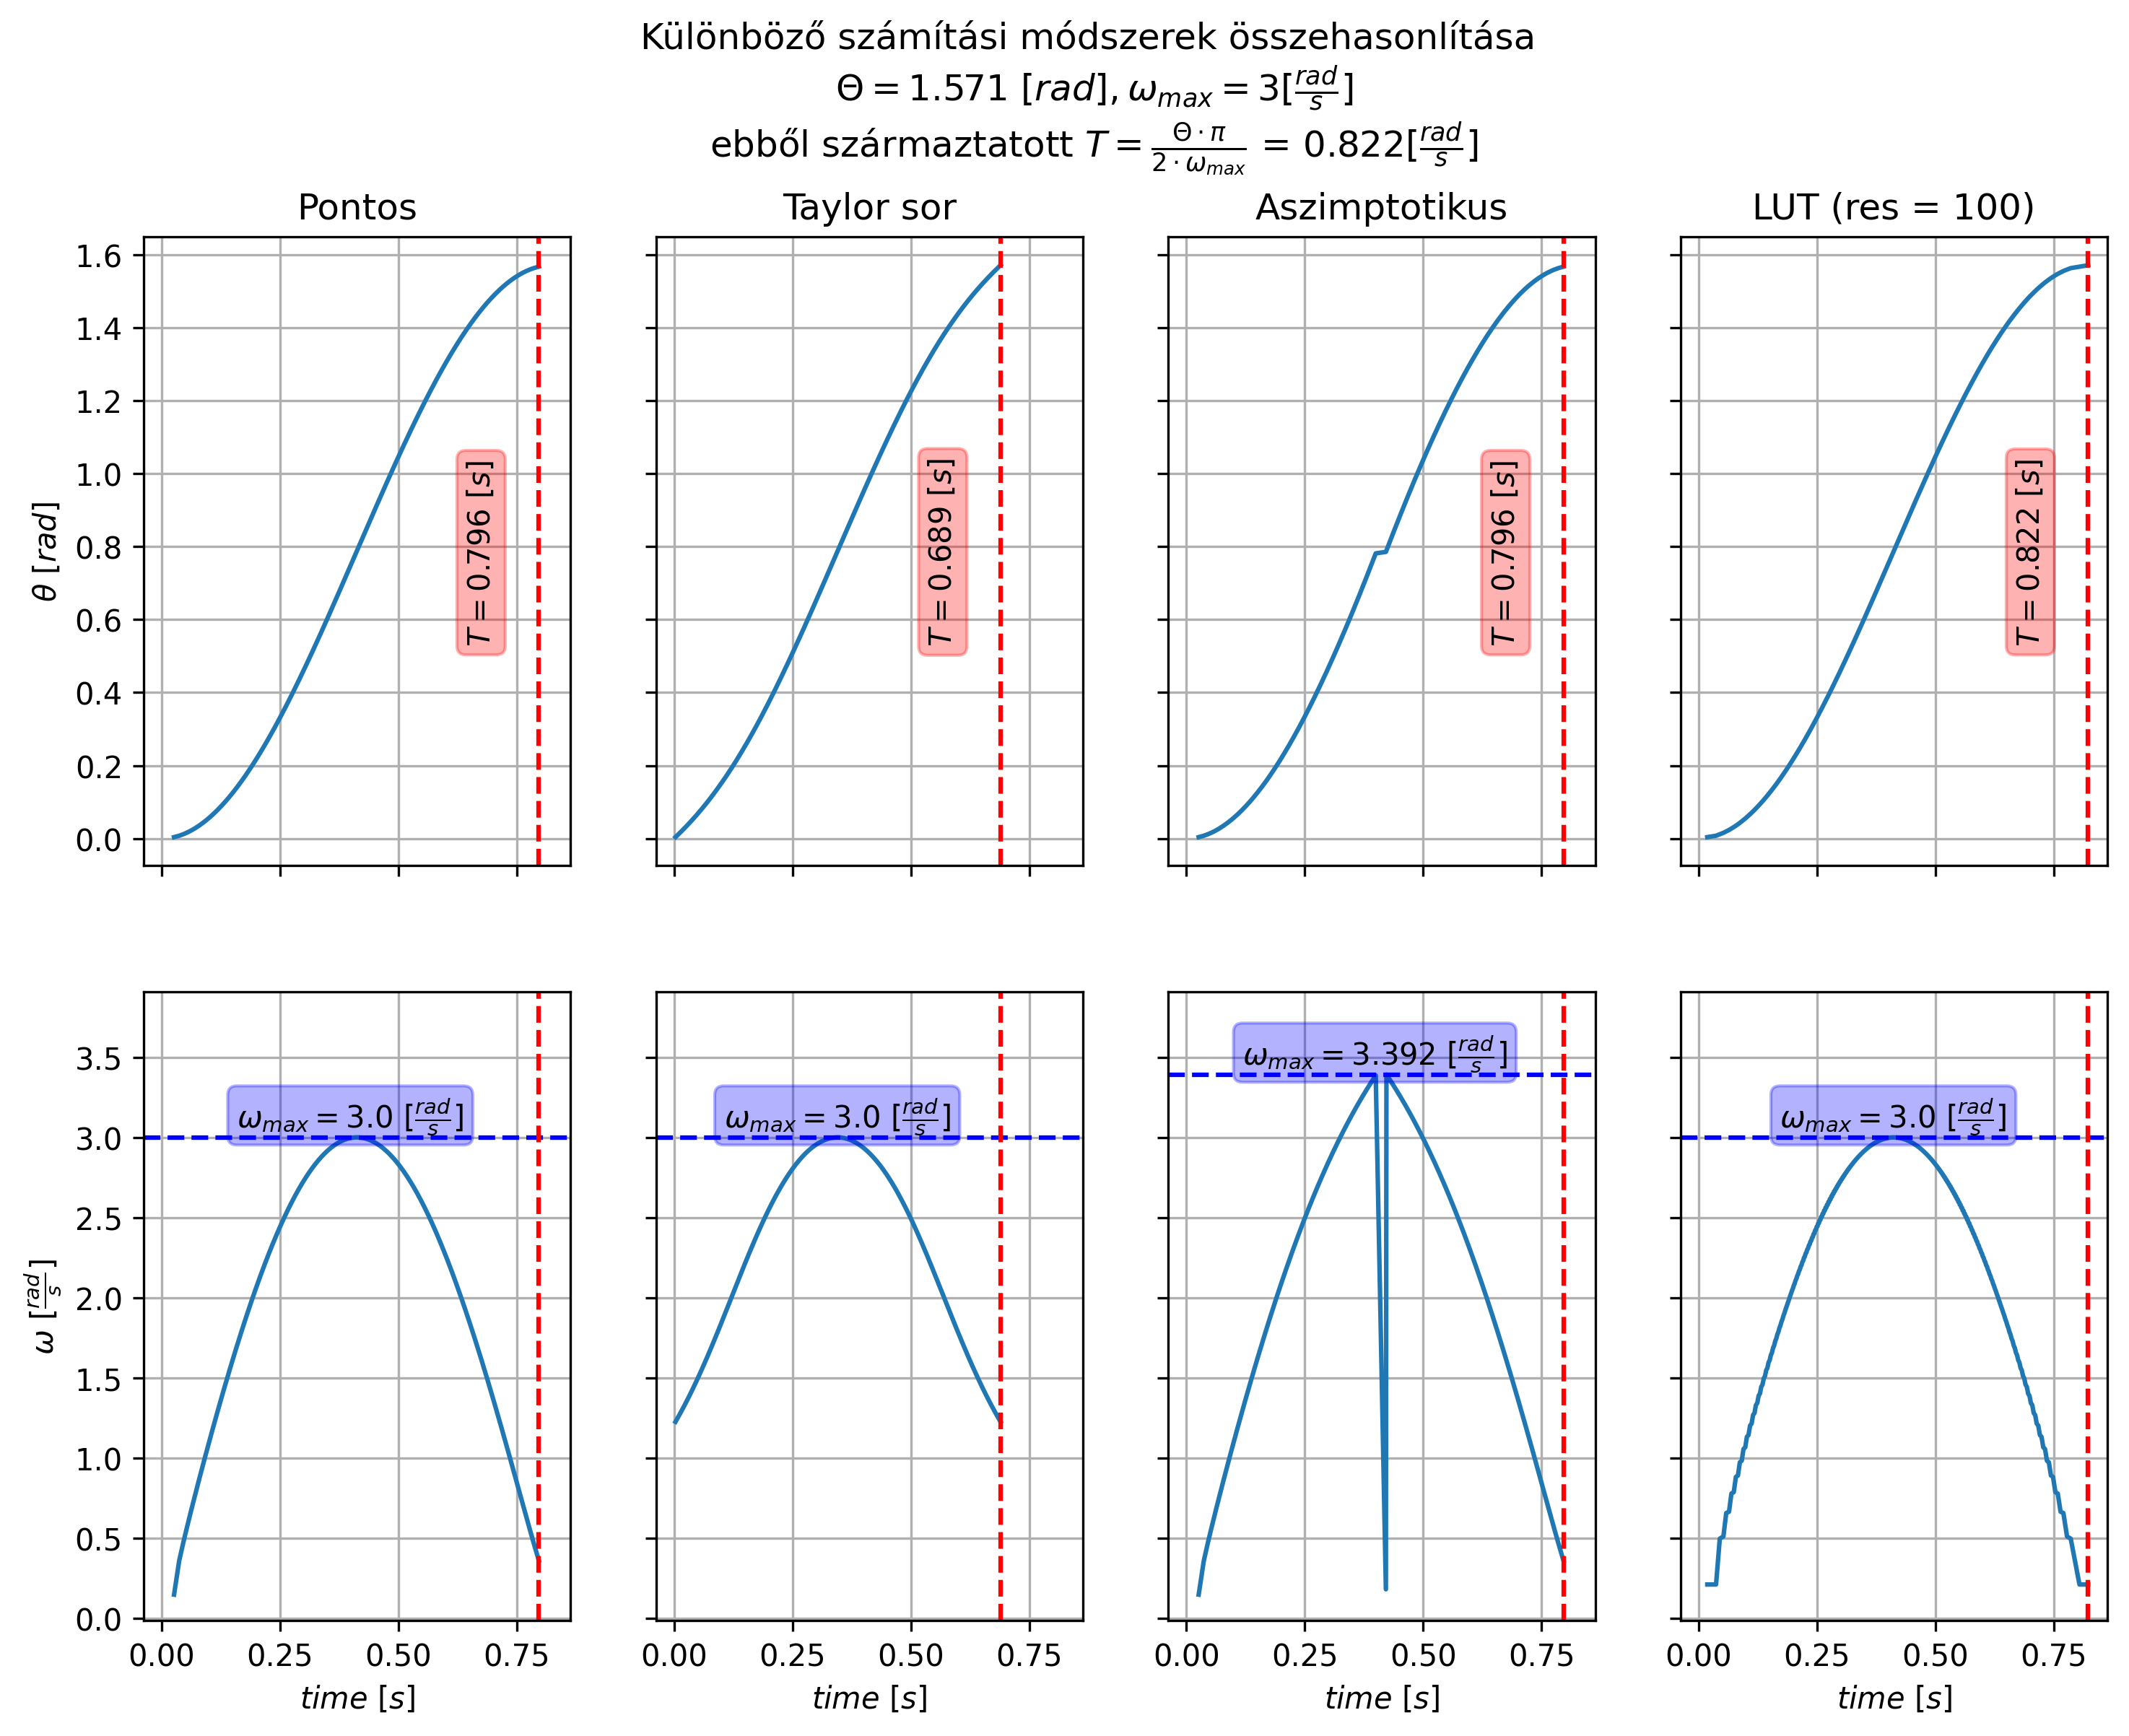

In [15]:
fig, ((ax11, ax12, ax13, ax14), (ax21, ax22, ax23, ax24)) = plt.subplots(2, 4, sharey = 'row', sharex = True)


omega_max_calculated = (Theta_rad * np.pi )/( 2 * T )

title = "Különböző számítási módszerek összehasonlítása \n" + \
        fr"$\Theta = {np.round(Theta_rad, 3)} \ [rad],$" + r"$\omega_{max} = $" + f"{omega_max}" +  r"$[\frac{rad}{s}]$" + "\n" \
        r"ebből származtatott $T = \frac{\Theta \cdot \pi}{2 \cdot \omega_{max}}$" + f" = {np.round(T, 3)}" + r"$[\frac{rad}{s}]$"

fig.suptitle(title, y = 1)

fig.set_size_inches(11.7,8.3)
fig.set_dpi(300)

ax11.plot(d_times_summed_exact, integrated_speed_exact)
ax21.plot(d_times_summed_exact, speed_exact)

ax21.axhline(np.nanmax(speed_exact), color = 'blue', ls = '--')
ax11.axvline(np.nanmax(d_times_summed_exact), color = 'red', ls = '--')
ax21.axvline(np.nanmax(d_times_summed_exact), color = 'red', ls = '--')

T_omega_texts(ax11, ax21, d_times_summed_exact, speed_exact, integrated_speed_exact, d_times_summed_exact)
ax11.set_title("Pontos")



ax12.plot(d_times_summed_taylor, integrated_speed_taylor)
ax22.plot(d_times_summed_taylor, speed_taylor)

ax22.axhline(speed_taylor.max(), color = 'blue', ls = '--')
ax12.axvline(d_times_summed_taylor[-1], color = 'red', ls = '--')
ax22.axvline(d_times_summed_taylor[-1], color = 'red', ls = '--')

T_omega_texts(ax12, ax22, d_times_summed_taylor, speed_taylor, integrated_speed_taylor, d_times_summed_taylor)
ax12.set_title("Taylor sor")



ax13.plot(d_times_summed_identity, integrated_speed_identity)
ax23.plot(d_times_summed_identity, speed_identity)

ax23.axhline(np.nanmax(speed_identity), color = 'blue', ls = '--')
ax13.axvline(np.nanmax(d_times_summed_identity), color = 'red', ls = '--')
ax23.axvline(np.nanmax(d_times_summed_identity), color = 'red', ls = '--')

T_omega_texts(ax13, ax23, d_times_summed_identity, speed_identity, integrated_speed_identity, d_times_summed_identity)
ax13.set_title("Aszimptotikus")



ax14.plot(d_times_summed_LUT, integrated_speed_LUT)
ax24.plot(d_times_summed_LUT, speed_LUT)

ax24.axhline(speed_LUT.max(), color = 'blue', ls = '--')
ax14.axvline(d_times_summed_LUT[-1], color = 'red', ls = '--')
ax24.axvline(d_times_summed_LUT[-1], color = 'red', ls = '--')

T_omega_texts(ax14, ax24, d_times_summed_LUT, speed_LUT, integrated_speed_LUT, d_times_summed_LUT)
ax14.set_title(f"LUT (res = {LUT_res})")

ax11.set_ylabel(r'$\theta\ [rad]$')
ax21.set_ylabel(r'$\omega\ [\frac{rad}{s}]$')

ax23.set_ylim(ax23.get_ylim()[0], ax23.get_ylim()[1]*1.1)

for ax in fig.get_axes():
    ax.grid()
    ax.set_xlabel(r'$time\ [s]$')
    ax.label_outer()

In [16]:
ax23.get_ylim()


(-0.0121437256089868, 3.909006488834539)

In [17]:
len(d_times_LUT)

400